# Import libraries + Read data

In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.sparse import vstack
import gc
import tensorflow as tf
from tqdm import tqdm
import re
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics import jaccard_score

# Read data
from google.colab import drive
drive.mount("/content/drive/")
%cd '/content/drive/MyDrive/DS340/Netflix'
!pwd
Movie_Title = pd.read_csv("movie_titles.csv", encoding = 'ISO-8859-1', header = None, names = ['Id', 'Year', 'Name']).set_index('Id')
data1 = pd.read_csv("combined_data_1.txt", header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
# data2 = pd.read_csv("combined_data_2.txt", header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
# data3 = pd.read_csv("combined_data_3.txt", header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
data4 = pd.read_csv("combined_data_4.txt", header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])

Mounted at /content/drive/
/content/drive/MyDrive/DS340/Netflix
/content/drive/MyDrive/DS340/Netflix


In [ ]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')
# remove unnecessary TF logs
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Merging Dataset

In [ ]:
# Random Sampling
#data1 = data1.sample(frac=0.01,replace=False)
#data2 = data2.sample(frac=0.01,replace=False)
#data3 = data3.sample(frac=0.01,replace=False)
#data4 = data4.sample(frac=0.01,replace=False)
# Merge 4 dataset
df = pd.concat([data1, data4]).reset_index(drop=True)
del data1, data4
_=gc.collect()

In [ ]:
Movie_Title

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


# Below Code is from Kaggle

Reference: https://www.kaggle.com/code/fanglidayan/10-netflix-movie-recommender-part-1 

In [ ]:
# Find empty rows to slice dataframe for each movie
tmp_movies = df[df['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]
# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)
# Gather all dataframes
user_data = []
# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
  if df_id_1<df_id_2:
    tmp_df = df.loc[df_id_1+1:df_id_2-1].copy()
  else:
    tmp_df = df.loc[df_id_1+1:].copy()
  
  tmp_df['Movie'] = movie_id
  user_data.append(tmp_df)

# Combine all dataframes
df_cleaned = pd.concat(user_data)
del user_data, df, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
df_cleaned.head()

,User,Rating,Date,Movie
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


# Novel Work - Heejun, So-I

In [ ]:
df_cleaned.drop(columns=['Date'],inplace=True)

In [ ]:
df_cleaned

,User,Rating,Movie
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
50910184,1790158,4.0,17770
50910185,1608708,3.0,17770
50910186,234275,1.0,17770
50910187,255278,4.0,17770


In [ ]:
Num_Rating = pd.DataFrame(df_cleaned.groupby('Movie')['Rating'].count())
Num_Rating = Num_Rating.rename(columns={"Rating": "Total No. Ratings"})
Avg_Rating = pd.DataFrame(df_cleaned.groupby('Movie')['Rating'].mean())
Avg_Rating = Avg_Rating.rename(columns={"Rating": "Avg. Ratings"})
Num_Rating

,Total No. Ratings
Movie,
1,547
2,145
3,2012
4,142
5,1140
...,...
17766,605
17767,204
17768,1362


In [ ]:
Avg_Rating

,Avg. Ratings
Movie,
1,3.749543
2,3.558621
3,3.641153
4,2.739437
5,3.919298
...,...
17766,3.193388
17767,3.671569
17768,2.839207


# Distribution of Average Ratings

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f8a02b050>]],
      dtype=object)

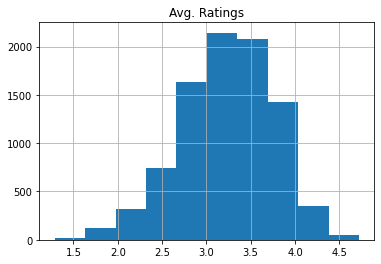

In [ ]:
Avg_Rating.hist()

# Distribution of Total Number of Ratings

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f980aa550>]],
      dtype=object)

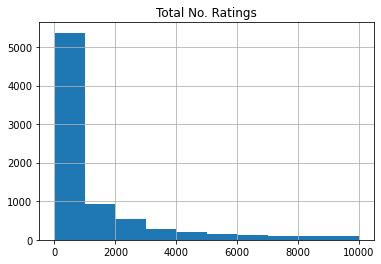

In [ ]:
Num_Rating[Num_Rating['Total No. Ratings'] < 10000].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6faf7d3b90>]],
      dtype=object)

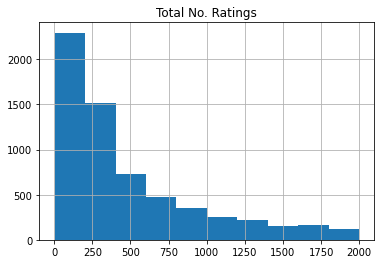

In [ ]:
Num_Rating[Num_Rating['Total No. Ratings'] < 2000].hist()

In [ ]:
Num_Rating.sort_values(by='Total No. Ratings', ascending= True)

,Total No. Ratings
Movie,
13755,3
16875,23
13405,29
16155,36
15197,36
...,...
16377,181426
1905,193941
15205,196397


# To see statistics

In [ ]:
a = Num_Rating.describe()
b = Avg_Rating.describe()
Summary = pd.merge(a,b,left_index=True, right_index=True)
Summary

,Total No. Ratings,Avg. Ratings
count,8902.000000,8902.000000
mean,5717.960795,3.233255
std,17131.397051,0.525582
min,3.000000,1.287879
25%,196.000000,2.908763
50%,574.000000,3.261366
75%,2603.750000,3.615177
max,216596.000000,4.723270


# Filter too few numbers of ratings for more accurate recommendation systems!

Threshold = 500

In [ ]:
# Filter out movies that have less than 500 reviews
Num_Rating = Num_Rating[Num_Rating['Total No. Ratings'] > 500].sort_values(by='Total No. Ratings', ascending=True)
Num_Rating

,Total No. Ratings
Movie,
2661,501
14361,502
1423,502
17544,502
15459,502
...,...
16377,181426
1905,193941
15205,196397


In [ ]:
# Merge filtered Num_Rating dataframe with Avg_Rating
Joined = Num_Rating.join(Avg_Rating, on='Movie', how='inner')
Joined

,Total No. Ratings,Avg. Ratings
Movie,,
2661,501,3.279441
14361,502,4.175299
1423,502,2.262948
17544,502,3.806773
15459,502,2.474104
...,...,...
16377,181426,4.306941
1905,193941,4.153908
15205,196397,3.442166


# Use external data to add Genre variable


In [ ]:
Genre = pd.read_csv("movies_metadata.csv")

In [ ]:
for i, title1 in tqdm(enumerate(Movie_Title['Name'].values)):
  for j, title2 in enumerate(Genre['original_title'].values):
    if title1 == title2:
      Movie_Title.at[i, 'genre'] = Genre['genres'][j]

17770it [02:37, 113.01it/s]


In [ ]:
Movie_Title = Movie_Title.dropna()
Movie_Title

,Year,Name,genre
Id,,,
9,1991.0,Class of Nuke 'Em High 2,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
11,1999.0,Full Frame: Documentary Shorts,"[{'id': 35, 'name': 'Comedy'}, {'id': 53, 'nam..."
15,1988.0,Neil Diamond: Greatest Hits Live,"[{'id': 99, 'name': 'Documentary'}, {'id': 107..."
16,1996.0,Screamers,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam..."
17,2005.0,7 Seconds,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n..."
...,...,...,...
17762,1997.0,Gattaca,"[{'id': 18, 'name': 'Drama'}]"
17763,1978.0,Interiors,"[{'id': 10749, 'name': 'Romance'}, {'id': 36, ..."
17767,2004.0,Fidel Castro: American Experience,"[{'id': 878, 'name': 'Science Fiction'}]"


# Export only Genre's id

In [ ]:
import re
Movie_Title['genre'] = Movie_Title['genre'].map(lambda x: re.findall(r'\d+', x))
Movie_Title = Movie_Title.rename_axis('Movie')
Movie_Title

,Year,Name,genre
Movie,,,
9,1991.0,Class of Nuke 'Em High 2,"[28, 18, 10749]"
11,1999.0,Full Frame: Documentary Shorts,"[35, 53, 9648, 10749]"
15,1988.0,Neil Diamond: Greatest Hits Live,"[99, 10769]"
16,1996.0,Screamers,"[28, 80, 53]"
17,2005.0,7 Seconds,"[18, 10402, 10749]"
...,...,...,...
17762,1997.0,Gattaca,[18]
17763,1978.0,Interiors,"[10749, 36]"
17767,2004.0,Fidel Castro: American Experience,[878]


In [ ]:
Movie_Title = Movie_Title.rename_axis('Movie')
Movie_Title

,Year,Name,genre
Movie,,,
9,1991.0,Class of Nuke 'Em High 2,"[28, 18, 10749]"
11,1999.0,Full Frame: Documentary Shorts,"[35, 53, 9648, 10749]"
15,1988.0,Neil Diamond: Greatest Hits Live,"[99, 10769]"
16,1996.0,Screamers,"[28, 80, 53]"
17,2005.0,7 Seconds,"[18, 10402, 10749]"
...,...,...,...
17762,1997.0,Gattaca,[18]
17763,1978.0,Interiors,"[10749, 36]"
17767,2004.0,Fidel Castro: American Experience,[878]


# Below Code shows why we need to use data1 and data4

- To have more movies with genres
- We can only use 2 out of 4 datasets due to memory capacity 

In [ ]:
print("MovieID between 1 and 4442: ", np.count_nonzero(Movie_Title.index < 4443))
print("MovieID between 4443 and 8884: ", np.count_nonzero(Movie_Title.index < 8885) - np.count_nonzero(Movie_Title.index < 4443))
print("MovieID between 8885 and 13326: ", np.count_nonzero(Movie_Title.index < 13327) - np.count_nonzero(Movie_Title.index < 8885))
print("MovieID between 13327 and 17769: ", np.count_nonzero(Movie_Title.index < 17770) - np.count_nonzero(Movie_Title.index < 13327))

MovieID between 1 and 4442:  1957
MovieID between 4443 and 8884:  1909
MovieID between 8885 and 13326:  1920
MovieID between 13327 and 17769:  1940


# Popularity Approach

- Recommend movies that have the most number of ratings

- Recommend movies that have the highest average ratings

In [ ]:
Top_Num = Joined.sort_values(by='Total No. Ratings', ascending=False)
Popularity_Num = pd.merge(Top_Num, Movie_Title, left_index=True, right_index=True)
Popularity_Num.head(20)

,Total No. Ratings,Avg. Ratings,Year,Name,genre
Movie,,,,,
15124,216596,3.724238,1996.0,Independence Day,"[18, 10749]"
16377,181426,4.306941,1999.0,The Green Mile,"[28, 12, 18, 53]"
2152,162597,3.425322,2000.0,What Women Want,"[10751, 12]"
14538,154640,3.551875,2003.0,How to Lose a Guy in 10 Days,"[18, 10402, 10749]"
2452,149866,4.434708,2001.0,Lord of the Rings: The Fellowship of the Ring,"[35, 16]"
1962,145519,3.750569,2004.0,50 First Dates,"[14, 18, 10749]"
16879,143668,3.709845,1997.0,Titanic,"[99, 10769]"
14550,139660,4.593384,1994.0,The Shawshank Redemption: Special Edition,[35]
3624,139428,3.946596,2003.0,The Last Samurai,"[18, 10402]"


In [ ]:
Top_Avg = Joined.sort_values(by='Avg. Ratings', ascending=False)
Popularity_Rating = pd.merge(Top_Avg, Movie_Title, left_index=True, right_index=True)
Popularity_Rating.head(20)

,Total No. Ratings,Avg. Ratings,Year,Name,genre
Movie,,,,,
15538,1633,4.605021,2004.0,Fullmetal Alchemist,"[18, 35]"
14550,139660,4.593384,1994.0,The Shawshank Redemption: Special Edition,[35]
2102,8426,4.581296,1994.0,The Simpsons: Season 6,"[878, 53]"
14240,134284,4.545121,2003.0,Lord of the Rings: The Return of the King,"[36, 18]"
16587,18413,4.523489,1992.0,The Simpsons: Season 4,"[18, 10749]"
13504,1592,4.522613,2004.0,House,"[12, 14]"
16265,85184,4.504097,1977.0,Star Wars: Episode IV: A New Hope,[18]
17307,11933,4.497025,2003.0,CSI: Season 4,[35]
16302,23254,4.484304,1999.0,Family Guy: Vol. 1: Seasons 1-2,"[16, 10751, 12, 878]"


# Content Based Filtering

- Use characteristics of movies to recommend

In [ ]:
# Avg. Rating by Movie ID
By_Movie = pd.DataFrame(df_cleaned.groupby('Movie')['Rating'].mean()).sort_values(by='Rating', ascending=False)
CB = pd.merge(By_Movie, Movie_Title, left_index=True, right_index=True)
CB

,Rating,Year,Name,genre
Movie,,,,
15538,4.605021,2004.0,Fullmetal Alchemist,"[18, 35]"
14550,4.593384,1994.0,The Shawshank Redemption: Special Edition,[35]
2102,4.581296,1994.0,The Simpsons: Season 6,"[878, 53]"
14240,4.545121,2003.0,Lord of the Rings: The Return of the King,"[36, 18]"
16587,4.523489,1992.0,The Simpsons: Season 4,"[18, 10749]"
...,...,...,...,...
1725,1.522137,2003.0,Ben & Arthur,"[12, 18, 10769]"
625,1.505034,1999.0,Underground Comedy Movie,"[18, 10749, 10752, 37]"
17577,1.400000,2003.0,Absolution,[18]


In [ ]:
# To use overview feature from metadata.csv
MetaData = pd.read_csv("movies_metadata.csv")[['original_title', 'overview', 'vote_count']].dropna()
MetaData = MetaData.rename(columns={"original_title": "Name"})
MetaData = MetaData.sort_values(by='vote_count', ascending=False)
MetaData

,Name,overview,vote_count
15480,Inception,"Cobb, a skilled thief who commits corporate es...",14075.0
12481,The Dark Knight,Batman raises the stakes in his war on crime. ...,12269.0
14551,Avatar,"In the 22nd century, a paraplegic Marine is di...",12114.0
17818,The Avengers,When an unexpected enemy emerges and threatens...,12000.0
26564,Deadpool,Deadpool tells the origin story of former Spec...,11444.0
...,...,...,...
29187,Screen Test,A group of sex-crazy guys pose as porno filmma...,0.0
29182,Boobs: An American Obsession,We call them by a hundred different names: boo...,0.0
29174,Tell Me a Riddle,Touching story of elderly couple David and Eva...,0.0
29171,Preppies,Three sexy young women are hired to ensure tha...,0.0


In [ ]:
# To check is there redundant movies for the same movie
MetaData_Dirt = MetaData.groupby('Name').count().sort_values(by='overview', ascending=False)
MetaData_Dirt

,overview,vote_count
Name,,
Alice in Wonderland,8,8
Hamlet,8,8
Macbeth,7,7
A Christmas Carol,7,7
Cinderella,7,7
...,...,...
If These Walls Could Talk,1,1
If These Walls Could Talk 2,1,1
If Tomorrow Comes,1,1


In [ ]:
# To remove redundant movies for the same movie
movies_with_multiple_overviews = MetaData_Dirt[MetaData_Dirt['overview'] > 1].index
for i in range(len(movies_with_multiple_overviews)):
  k = MetaData[MetaData['Name'] == movies_with_multiple_overviews[i]]
  MetaData.drop(k.index[1:],inplace=True)
MetaData

,Name,overview,vote_count
15480,Inception,"Cobb, a skilled thief who commits corporate es...",14075.0
12481,The Dark Knight,Batman raises the stakes in his war on crime. ...,12269.0
14551,Avatar,"In the 22nd century, a paraplegic Marine is di...",12114.0
17818,The Avengers,When an unexpected enemy emerges and threatens...,12000.0
26564,Deadpool,Deadpool tells the origin story of former Spec...,11444.0
...,...,...,...
29187,Screen Test,A group of sex-crazy guys pose as porno filmma...,0.0
29182,Boobs: An American Obsession,We call them by a hundred different names: boo...,0.0
29174,Tell Me a Riddle,Touching story of elderly couple David and Eva...,0.0
29171,Preppies,Three sexy young women are hired to ensure tha...,0.0


In [ ]:
MetaData.nunique()

Name          42442
overview      42283
vote_count     1811
dtype: int64

In [ ]:
MetaData.groupby('overview').count().sort_values(by='Name', ascending=False)

,Name,vote_count
overview,,
No overview found.,130,130
No Overview,7,7
,5,5
A few funny little novels about different aspects of life.,3,3
No movie overview available.,3,3
...,...,...
"Bilal is 17 years old, a Kurdish boy from Iraq. He sets off on an adventure-filled journey across Europe. He wants to get to England to see his love who lives there. Bilal finally reaches Calais, but how do you cover 32 kilometers of the English Channel when you can't swim? The boy soon discovers that his trip won't be as easy as he imagined... The community of struggling illegal aliens in Calais",1,1
"Bilbao. The commander of the Guardia Civil, Evaristo Torrecuadrada discovers that his son Paco of 17 years old is a heroin addict. His hope was to see him in the Military Academy. Paco, by differences with his father, runs away from home with a pistol. The commander begins his quest aided by co-Body, using the means at its disposal to achieve its objective. Lt. Alcantara, an expert on drugs, will be one of the most prominent in this quest. The Civil Guard Commander begins to discover a world that knew nothing. Urko's father, nationalist leader with a heroin adict son, helps in some way to find out. His principles, his life, his struggle, fall into a deep crisis, exacerbated by the developments ...",1,1
"Bilbo Baggins the Hobbit was just minding his own business, when his occasional visitor Gandalf the Wizard drops in one night. One by one, a whole group of dwarves drop in, and before he knows it, Bilbo has joined their quest to reclaim their kingdom, taken from them by the evil dragon Smaug. The only problem is that Gandalf has told the dwarves that Bilbo is an expert burglar, but he isn't...",1,1


# Found that some movies do not have appropriate overview data

### Need to remove them!

In [ ]:
Remove_word1 = ['No', 'overview']
Remove_word2 = ['No', 'Overview']
Test1 = MetaData[MetaData['overview'].map(lambda x: all(string in x for string in Remove_word1))]
Test2 = MetaData[MetaData['overview'].map(lambda x: all(string in x for string in Remove_word2))]
Test = pd.concat([Test1, Test2])
Test

,Name,overview,vote_count
31873,Il cosmo sul comò,No overview found.,156.0
25920,"Grande, grosso e Verdone",No overview found.,78.0
32082,Fantozzi subisce ancora,No overview found.,77.0
9906,Tanguy,No overview found.,70.0
19265,Mais qui a tué Pamela Rose ?,No overview found.,62.0
...,...,...,...
41869,Mounted Police Charge,No Overview,2.0
41868,"Fifth Avenue, New York",No Overview,1.0
41881,Gold Rush Scenes in the Klondike,No Overview,1.0
39836,Autobiography of a Princess,No Overview,1.0


In [ ]:
movies_with_no_overview = Test['Name'].values
for i in range(len(movies_with_no_overview)):
  L = MetaData[MetaData['Name'] == movies_with_no_overview[i]]
  MetaData.drop(L.index[0],inplace=True)
MetaData

,Name,overview,vote_count
15480,Inception,"Cobb, a skilled thief who commits corporate es...",14075.0
12481,The Dark Knight,Batman raises the stakes in his war on crime. ...,12269.0
14551,Avatar,"In the 22nd century, a paraplegic Marine is di...",12114.0
17818,The Avengers,When an unexpected enemy emerges and threatens...,12000.0
26564,Deadpool,Deadpool tells the origin story of former Spec...,11444.0
...,...,...,...
29187,Screen Test,A group of sex-crazy guys pose as porno filmma...,0.0
29182,Boobs: An American Obsession,We call them by a hundred different names: boo...,0.0
29174,Tell Me a Riddle,Touching story of elderly couple David and Eva...,0.0
29171,Preppies,Three sexy young women are hired to ensure tha...,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7df9ee490>]],
      dtype=object)

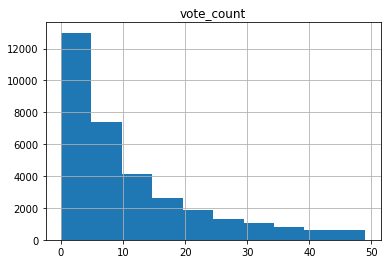

In [ ]:
MetaData[MetaData['vote_count'] < 50].hist()

In [ ]:
CB = pd.merge(CB, MetaData, how='inner', on='Name')
CB.drop(columns=['vote_count'])

,Rating,Year,Name,genre,overview
0,4.522613,2004.0,House,"[12, 14]",Roger Cobb is a author who has just separated ...
1,4.404083,1974.0,The Godfather,[99],"Spanning the years 1945 to 1955, a chronicle o..."
2,4.306941,1999.0,The Green Mile,"[28, 12, 18, 53]",A supernatural tale set on death row in a Sout...
3,4.302888,2004.0,Farscape: The Peacekeeper Wars,[27],Sixty days on and Rygel is retrieving pieces o...
4,4.295087,1998.0,Saving Private Ryan,"[10751, 12, 18, 14]","As U.S. troops storm the beaches of Normandy, ..."
...,...,...,...,...,...
1708,1.900552,2002.0,Deadly Species,"[18, 9648, 53, 14]","Wealthy big game hunter, Wilson Frields, funds..."
1709,1.839891,1989.0,Going Overboard,[18],A struggling young comedian takes a menial job...
1710,1.740541,2004.0,The Trip,"[18, 36, 10749]",When Steve Coogan is asked by The Observer to ...
1711,1.739496,1997.0,Future War,"[28, 27, 53]",A runaway human slave from Earth's future esca...


In [ ]:
# Need to remove redundant movies
CB_Dirt = CB.groupby('Name').count().sort_values(by='overview', ascending=False)
Redundant = CB_Dirt[CB_Dirt['overview'] > 1].index
for i in range(len(Redundant)):
  k = CB[CB['Name'] == Redundant[i]]
  CB.drop(k.index[1:])
CB

,Rating,Year,Name,genre,overview,vote_count
0,4.522613,2004.0,House,"[12, 14]",Roger Cobb is a author who has just separated ...,144.0
1,4.404083,1974.0,The Godfather,[99],"Spanning the years 1945 to 1955, a chronicle o...",6024.0
2,4.306941,1999.0,The Green Mile,"[28, 12, 18, 53]",A supernatural tale set on death row in a Sout...,4166.0
3,4.302888,2004.0,Farscape: The Peacekeeper Wars,[27],Sixty days on and Rygel is retrieving pieces o...,74.0
4,4.295087,1998.0,Saving Private Ryan,"[10751, 12, 18, 14]","As U.S. troops storm the beaches of Normandy, ...",5148.0
...,...,...,...,...,...,...
1708,1.900552,2002.0,Deadly Species,"[18, 9648, 53, 14]","Wealthy big game hunter, Wilson Frields, funds...",3.0
1709,1.839891,1989.0,Going Overboard,[18],A struggling young comedian takes a menial job...,44.0
1710,1.740541,2004.0,The Trip,"[18, 36, 10749]",When Steve Coogan is asked by The Observer to ...,117.0
1711,1.739496,1997.0,Future War,"[28, 27, 53]",A runaway human slave from Earth's future esca...,11.0


# Below code is from Kaggle

Reference: https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/notebook 

In [ ]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(CB['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(1713, 12579)

In [ ]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(CB.index, index=CB['Name']).drop_duplicates()
def get_recommendations(Name, cosine_sim=cosine_sim):
  idx = indices[Name]

  # Get the pairwsie similarity scores of all movies with that movie
  sim_scores = list(enumerate(cosine_sim[idx]))

  # Sort the movies based on the similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # Get the scores of the 20 most similar movies
  sim_scores = sim_scores[1:21]

  # Get the movie indices
  movie_indices = [i[0] for i in sim_scores]
  return CB['Name'].iloc[movie_indices]

In [ ]:
# To check the function works appropriately
get_recommendations('House')

1134                          Burnt Offerings
1231                                  Beloved
1005                                    Oasis
1052                       Opportunity Knocks
1424                             Doppelganger
172                           Beautiful Thing
1547                                 Darkness
1495                             The Tall Guy
1583                        Saturday the 14th
1705               The House of Seven Corpses
368                                The Others
658                    Where the Buffalo Roam
704                                  Deadline
762                         Casualties of War
888                The Great Locomotive Chase
123     VeggieTales: The Ballad of Little Joe
1379                                  Hey Ram
857                  The Legend of Hell House
19                          Dial M for Murder
510                     House of Sand and Fog
Name: Name, dtype: object

# Novel Work: 
# Content-Based Filtering by genre of movies

In [ ]:
# Define Jaccard Similarity
def jaccard(a, b):
    intersect = len(list(set(a).intersection(b)))
    union = (len(a) + len(b)) - intersect
    return float(intersect) / union
# Make Recommendation System
def CB_Recommender(Name):
  Jac_Sim = pd.DataFrame(columns = ['Name', 'Jac_Sim'])
  for i in range(len(CB['genre'])):
    good = CB[CB['Name'] == Name]['genre'][CB[CB['Name'] == Name]['genre'].index[0]]
    score = jaccard(good, CB['genre'][i])
    titles = CB['Name'][i]
    Jac_Sim = Jac_Sim.append({'Name':titles,'Jac_Sim':score}, ignore_index=True)
    Jac_Sim = Jac_Sim.sort_values(by='Jac_Sim', ascending= False)
    Jac_Sim = Jac_Sim[Jac_Sim['Jac_Sim'] < 1.0]
  return Jac_Sim.head(20)

In [ ]:
CB_Recommender('House')

,Name,Jac_Sim
0,Nine to Five,0.666667
7,Double Team,0.666667
1,Velvet Goldmine,0.666667
11,Jane Eyre,0.666667
10,Three Fugitives,0.666667
8,Superman III,0.666667
9,Amateur,0.666667
6,Dodge City,0.666667
5,Modern Times,0.666667
4,Neverland,0.666667


# Collaborative Filtering
- Use users' information history for recommendation systems

# Since dataset is too large, we decided to filter top n users who reviewd the movies most.
- n = 100

In [ ]:
Top_Users = pd.DataFrame(df_cleaned.groupby('User')['Rating'].count().sort_values(ascending= False))
Top_Users = Top_Users.head(100)
Top_Users

,Rating
User,
305344,8845
387418,8732
2439493,8321
1664010,7927
2118461,7457
...,...
2150746,1935
402266,1932
147386,1924


In [ ]:
CF_base = pd.DataFrame(columns = ['User', 'Rating', 'Movie'])
for i in range(len(Top_Users.index)):
  a = df_cleaned[df_cleaned['User'] == Top_Users.index[i]]
  CF_base = CF_base.append(a, ignore_index=True)
CF_base 

,User,Rating,Movie
0,305344,1.0,1
1,305344,1.0,2
2,305344,2.0,3
3,305344,1.0,4
4,305344,1.0,5
...,...,...,...
292255,1984315,4.0,17751
292256,1984315,3.0,17761
292257,1984315,5.0,17762
292258,1984315,4.0,17763


# Modulde "Surprise" is introduced by **The Journal of Open Source Software**"

- Reference: Hug, N., (2020). Surprise: A Python library for recommender systems. Journal of Open Source Software, 5(52), 2174. https://doi.org/10.
21105/joss.02174

In [ ]:
pip install scikit-surprise

# Below code based on Kaggle code!

- We built our code on top of Kaggle code!

- Reference: https://www.kaggle.com/code/jieyima/netflix-recommendation-collaborative-filtering/notebook 

In [ ]:
from surprise import Reader, Dataset, SVD
# from surprise.model_selection import cross_validate
reader = Reader()
svd = SVD()
def CF_Recommender(User):
  CF_Title = Movie_Title[['Year', 'Name']].reset_index()
  # getting full dataset
  data = Dataset.load_from_df(CF_base[['User', 'Movie', 'Rating']], reader)
  trainset = data.build_full_trainset()
  svd.fit(trainset)
  CF_Title['Score'] = CF_Title['Movie'].apply(lambda x: svd.predict(User, x).est)
  CF_Title = CF_Title[['Year', 'Name', 'Score']]
  CF_Title = CF_Title.sort_values('Score', ascending=False)
  return(CF_Title.head(20))

In [ ]:
CF_Recommender(305344)

,Year,Name,Score
7061,1977.0,Star Wars: Episode IV: A New Hope,4.300526
6198,2003.0,Lord of the Rings: The Return of the King,4.276216
7450,1998.0,Saving Private Ryan,4.240121
6336,1994.0,The Shawshank Redemption: Special Edition,4.212019
1073,2001.0,Lord of the Rings: The Fellowship of the Ring,4.180248
1212,1995.0,Braveheart,4.123793
1441,1974.0,The Godfather,4.072263
1715,2005.0,Batman Begins,4.052705
7111,1999.0,The Green Mile,4.042275
6808,1977.0,Close Encounters of the Third Kind,4.028706


# Hybrid Approach

- Combine Content-Based Filtering with Collaborative Filtering